In [2]:
import cv2  # For image processing
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import kagglehub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score
from kerastuner.tuners import Hyperband, RandomSearch

<ipython-input-2-cb86c443af67>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband, RandomSearch


In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    labels = []

    for label_folder in os.listdir(folder):
        # Skip hidden files and folders like .DS_Store
        if label_folder.startswith('.'):
            continue

        label_path = os.path.join(folder, label_folder)
        # Check if it's actually a directory
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    if label_folder == 'NORMAL':
                        labels.append(0)
                    else:
                        labels.append(1)

    return np.array(images), np.array(labels)

def flatten_images(images):
    n_samples = images.shape[0]
    return images.reshape((n_samples, -1))  # Flatten each image

In [5]:
train = '/content/drive/MyDrive/CS464 project/chest_xray/train'
val =  '/content/drive/MyDrive/CS464 project/chest_xray/val'
test = '/content/drive/MyDrive/CS464 project/chest_xray/test'

train_X, train_Y =load_images_from_folder(train, img_size=(128, 128))
val_X, val_Y =load_images_from_folder(val, img_size=(128, 128))
test_X, test_Y =load_images_from_folder(test, img_size=(128, 128))

train_X = flatten_images(train_X)
val_X = flatten_images(val_X)
test_X = flatten_images(test_X)

In [6]:
train_X = np.concatenate((val_X, train_X), axis=0)
train_Y = np.concatenate((val_Y, train_Y), axis=0)

In [7]:
train_X = train_X.reshape(-1, 128, 128, 1)/255.0
test_X = test_X.reshape(-1, 128, 128, 1)/255.0

In [8]:
# Function to tune layers, filters, kernels, and dropouts
def tune_model_structure():
    def build_model_structure(hp):
        model = Sequential()

        # Add convolutional layers with tunable parameters
        for i in range(hp.Int('num_conv_layers', 2, 4)):
            model.add(Conv2D(
                filters=hp.Choice(f'filters_{i}', values=[32, 64, 128]),
                kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
                activation=None,
                input_shape=(128, 128, 1) if i == 0 else None
            ))
            model.add(LeakyReLU(alpha=hp.Choice('leaky_relu_alpha', values=[0.01, 0.1])))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())

        # Add dense layers with tunable parameters
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(Dense(
                units=hp.Choice(f'units_dense_{i}', values=[64, 128, 256]),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    tuner = RandomSearch(
        build_model_structure,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_structure',
        project_name='structure_tuning'
    )

    tuner.search(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters for model structure:")
    print(best_hps.values)

    return tuner

In [9]:
def tune_batch_size():
    def build_model_batch(hp):
        model = Sequential([
            Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    batch_sizes = [i for i in range(8, 65, 2)]
    batch_results = []

    for batch_size in batch_sizes:
        model = build_model_batch(None)
        history = model.fit(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=batch_size, verbose=1)
        val_accuracy = max(history.history['val_accuracy'])
        batch_results.append((batch_size, val_accuracy))

    best_batch_size = max(batch_results, key=lambda x: x[1])[0]
    print(f"Best batch size: {best_batch_size}")

    return batch_results

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8469294309616089

Best val_accuracy So Far: 0.9367552995681763
Total elapsed time: 00h 03m 08s
Best hyperparameters for model structure:
{'num_conv_layers': 4, 'filters_0': 128, 'kernel_size_0': 3, 'leaky_relu_alpha': 0.1, 'filters_1': 128, 'kernel_size_1': 5, 'num_dense_layers': 1, 'units_dense_0': 64, 'dropout_rate_0': 0.4, 'filters_2': 64, 'kernel_size_2': 5, 'filters_3': 32, 'kernel_size_3': 5, 'units_dense_1': 64, 'dropout_rate_1': 0.30000000000000004}
Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9190 - loss: 0.6789 - val_accuracy: 0.5930 - val_loss: 0.8887
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9532 - loss: 0.1285 - val_accuracy: 0.8139 - val_loss: 0.5390
Epoch 3/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9636 - loss: 0.1009 - val_accuracy: 0.8772 - val_loss: 0.4300
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9644 - loss: 0.0977 - val_accuracy: 0.71

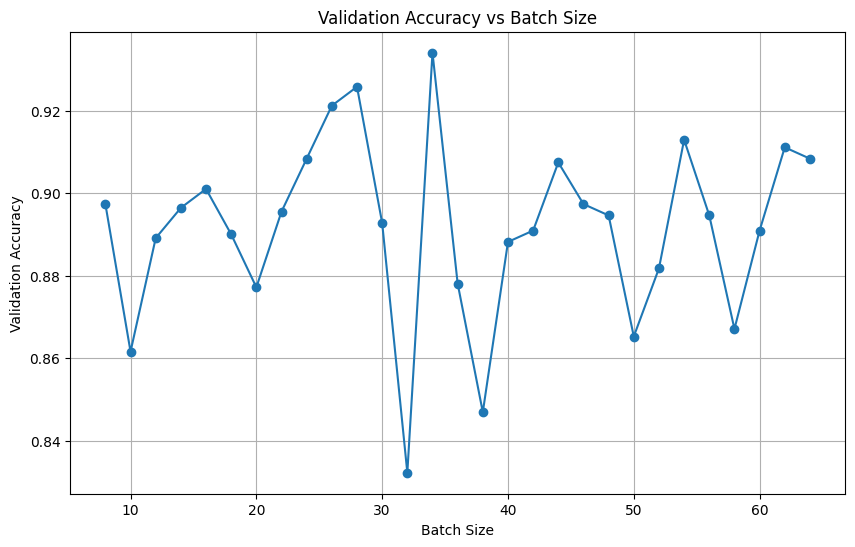

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8900 - loss: 0.3711 - val_accuracy: 0.0037 - val_loss: 1.5589
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9156 - loss: 0.2232 - val_accuracy: 0.0651 - val_loss: 2.5118
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9295 - loss: 0.1874 - val_accuracy: 0.5041 - val_loss: 1.1554
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9432 - loss: 0.1408 - val_accuracy: 0.4950 - val_loss: 1.3940
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9461 - loss: 0.1478 - val_accuracy: 0.7094 - val_loss: 0.8272
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9570 - loss: 0.1153 - val_accuracy: 0.6279 - val_loss: 0.8780
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9545 - loss: 0.1254 - val_accuracy: 0.8671 - val_loss: 0.3645
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9617 - loss: 0.1119 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9154 - loss: 0.2955 - val_accuracy: 0.2658 - val_loss: 1.8818
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9358 - loss: 0.1728 - val_accuracy: 0.5692 - val_loss: 1.0224
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9542 - loss: 0.1189 - val_accuracy: 0.6920 - val_loss: 0.7608
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9634 - loss: 0.1051 - val_accuracy: 0.9358 - val_loss: 0.2014
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9643 - loss: 0.1007 - val_accuracy: 0.8781 - val_loss: 0.3423
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9684 - loss: 0.0853 - val_accuracy: 0.8295 - val_loss: 0.4612
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9733 - loss: 0.0700 - val_accuracy: 0.8873 - val_loss: 0.3349
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9742 - loss: 0.0673 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9149 - loss: 0.3062 - val_accuracy: 0.3520 - val_loss: 1.0233
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9352 - loss: 0.1751 - val_accuracy: 0.3382 - val_loss: 1.1624
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9414 - loss: 0.1469 - val_accuracy: 0.6251 - val_loss: 0.8847
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9501 - loss: 0.1407 - val_accuracy: 0.0981 - val_loss: 2.8551
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9549 - loss: 0.1188 - val_accuracy: 0.6874 - val_loss: 0.7461
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9595 - loss: 0.1134 - val_accuracy: 0.9120 - val_loss: 0.2991
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9547 - loss: 0.1177 - val_accuracy: 0.9166 - val_loss: 0.3178
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9628 - loss: 0.0962 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9185 - loss: 0.3263 - val_accuracy: 0.1742 - val_loss: 1.5438
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9214 - loss: 0.2046 - val_accuracy: 0.1008 - val_loss: 2.2102
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9369 - loss: 0.1744 - val_accuracy: 0.5280 - val_loss: 1.0859
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9549 - loss: 0.1201 - val_accuracy: 0.8588 - val_loss: 0.3964
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9609 - loss: 0.1127 - val_accuracy: 0.7855 - val_loss: 0.6000
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9640 - loss: 0.0992 - val_accuracy: 0.8772 - val_loss: 0.3401
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9618 - loss: 0.0874 - val_accuracy: 0.8185 - val_loss: 0.4980
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9732 - loss: 0.0755 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8839 - loss: 0.3400 - val_accuracy: 0.0082 - val_loss: 2.0740
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9237 - loss: 0.2006 - val_accuracy: 0.1668 - val_loss: 1.8075
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9382 - loss: 0.1691 - val_accuracy: 0.7562 - val_loss: 0.6843
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9382 - loss: 0.1358 - val_accuracy: 0.7855 - val_loss: 0.5870
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9587 - loss: 0.1183 - val_accuracy: 0.7351 - val_loss: 0.7163
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9556 - loss: 0.1151 - val_accuracy: 0.6884 - val_loss: 0.8490
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9633 - loss: 0.1096 - val_accuracy: 0.9138 - val_loss: 0.2916
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9590 - loss: 0.1058 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8885 - loss: 0.2786 - val_accuracy: 0.4473 - val_loss: 1.2030
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9446 - loss: 0.1544 - val_accuracy: 0.7892 - val_loss: 0.5423
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9467 - loss: 0.1361 - val_accuracy: 0.7965 - val_loss: 0.5341
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9611 - loss: 0.0981 - val_accuracy: 0.6462 - val_loss: 0.8401
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9615 - loss: 0.1010 - val_accuracy: 0.8258 - val_loss: 0.5115
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9663 - loss: 0.0853 - val_accuracy: 0.7479 - val_loss: 0.7219
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9747 - loss: 0.0643 - val_accuracy: 0.8460 - val_loss: 0.5254
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9701 - loss: 0.0776 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9046 - loss: 0.3620 - val_accuracy: 0.0000e+00 - val_loss: 2.3696
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9261 - loss: 0.2197 - val_accuracy: 0.3456 - val_loss: 1.7405
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9389 - loss: 0.1584 - val_accuracy: 0.4876 - val_loss: 1.0822
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9510 - loss: 0.1350 - val_accuracy: 0.8048 - val_loss: 0.4906
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9522 - loss: 0.1279 - val_accuracy: 0.4005 - val_loss: 1.6277
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9562 - loss: 0.1219 - val_accuracy: 0.8433 - val_loss: 0.4022
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9686 - loss: 0.0886 - val_accuracy: 0.7259 - val_loss: 0.6803
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9676 - loss: 0.0884 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8851 - loss: 0.3451 - val_accuracy: 0.0000e+00 - val_loss: 2.0670
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9244 - loss: 0.2109 - val_accuracy: 0.6315 - val_loss: 0.7479
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9447 - loss: 0.1535 - val_accuracy: 0.5096 - val_loss: 1.1725
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9462 - loss: 0.1499 - val_accuracy: 0.7644 - val_loss: 0.6556
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9536 - loss: 0.1175 - val_accuracy: 0.7470 - val_loss: 0.6848
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9609 - loss: 0.1110 - val_accuracy: 0.6746 - val_loss: 0.7895
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9630 - loss: 0.1056 - val_accuracy: 0.8313 - val_loss: 0.4654
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9662 - loss: 0.0831 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9069 - loss: 0.3504 - val_accuracy: 0.2209 - val_loss: 1.5680
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9337 - loss: 0.1680 - val_accuracy: 0.4161 - val_loss: 1.2184
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9545 - loss: 0.1366 - val_accuracy: 0.7140 - val_loss: 0.7659
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9589 - loss: 0.1286 - val_accuracy: 0.7159 - val_loss: 0.6980
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9545 - loss: 0.1173 - val_accuracy: 0.8854 - val_loss: 0.3570
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9581 - loss: 0.1119 - val_accuracy: 0.7241 - val_loss: 0.7422
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9633 - loss: 0.1023 - val_accuracy: 0.8708 - val_loss: 0.4187
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9615 - loss: 0.0870 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8784 - loss: 0.4108 - val_accuracy: 0.2365 - val_loss: 1.0507
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9208 - loss: 0.1944 - val_accuracy: 0.5362 - val_loss: 1.2468
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9421 - loss: 0.1432 - val_accuracy: 0.5454 - val_loss: 1.1552
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9492 - loss: 0.1333 - val_accuracy: 0.5811 - val_loss: 0.9405
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9599 - loss: 0.1068 - val_accuracy: 0.6700 - val_loss: 1.0127
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9583 - loss: 0.1126 - val_accuracy: 0.8680 - val_loss: 0.4127
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9703 - loss: 0.0882 - val_accuracy: 0.7727 - val_loss: 0.6631
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9679 - loss: 0.0803 - val_accuracy: 0

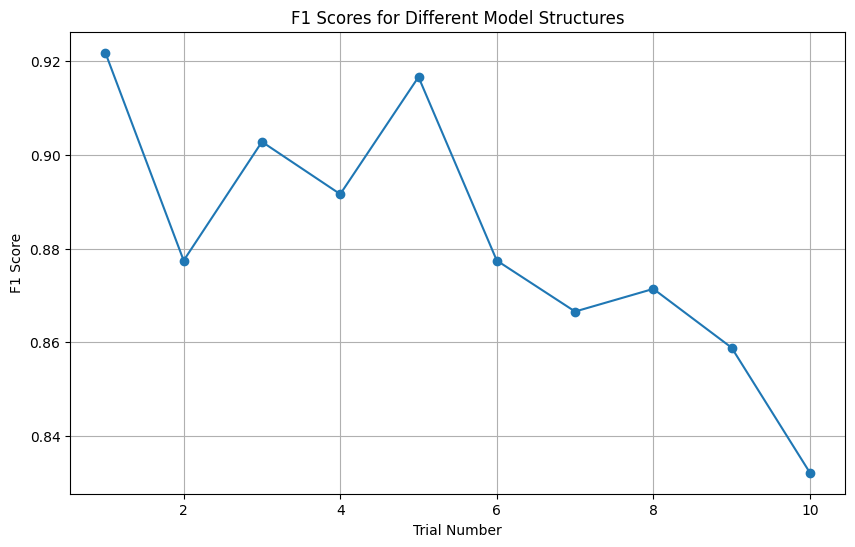

In [10]:
# Plot results
def plot_tuning_results(batch_results, structure_tuner):
    # Plot batch size results
    batch_sizes, accuracies = zip(*batch_results)
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, accuracies, marker='o')
    plt.title('Validation Accuracy vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Validation Accuracy')
    plt.grid()
    plt.show()

    # Plot structure tuning results
    trials = structure_tuner.oracle.get_best_trials(num_trials=10)
    f1_scores = []

    for trial in trials:
        hps = trial.hyperparameters
        temp_model = structure_tuner.hypermodel.build(hps)
        temp_model.fit(train_X, train_Y, validation_split=0.2, epochs=10, batch_size=32, verbose=1)
        y_pred = temp_model.predict(test_X)
        y_pred_classes = (y_pred > 0.5).astype('int32')
        temp_f1 = f1_score(test_Y, y_pred_classes)
        f1_scores.append(temp_f1)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
    plt.title('F1 Scores for Different Model Structures')
    plt.xlabel('Trial Number')
    plt.ylabel('F1 Score')
    plt.grid()
    plt.show()

# Execute all tuning and plotting steps
def execute_tuning_and_plotting():
    structure_tuner = tune_model_structure()
    batch_results = tune_batch_size()
    plot_tuning_results(batch_results, structure_tuner)

# Call the execution function
execute_tuning_and_plotting()